In [1]:
# load a matrix from a space-separated file and show it as an image
import sys
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/')
sys.path.append('/homes/ar2342/one_more_dir/contextual_frogs/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from optimise_clnn import load_subject_data
from memory_upd_utils import polarity, extract_mem_updates


In [2]:
def load_adaptation_trace(file_path): 
        df = pd.read_csv(file_path)
        arr = df.Adaptation.to_numpy()
        return arr

In [3]:
LOSS_IS_PER_SAMPLE = False
result_root = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/results/'
coin_bics_path = '/homes/ar2342/one_more_dir/contextual_frogs/experimental/optim/coin_bics.txt'
paradigm_ = {k: 'evoked' if k <= 8 else 'spontaneous' for k in range(1,17)}
coin_bics = np.loadtxt(coin_bics_path)
# exp_datasets = [ load_adaptation_trace(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_{paradigm_[i]}_recovery_participant{(i-1)%8+1}.csv') for i in range(1,17)]
exp_datasets = []
loss_traces= {}
output_traces= {}
prior_out_batch = {}
posterior_out_batch = {}
for i in range(1,25): 
    exp_datasets.append(load_subject_data(f'/homes/ar2342/frogs_project/data/COIN_data/trial_data_memory_updating_participant{i}.csv'))
    for j in range(1,2):
        # result_dir = f'mem_upd_try3/run_participant{i}_seed{j}' 
        result_dir = f'mem_upd_try5/run{i}_seed{j}' 
        aux_result_dir = f'mem_upd_try3Final/run{i}_seed{j}'
        try: 
            loss_traces[(i,j)] = np.genfromtxt(f'{result_root}/{result_dir}/loss.csv', delimiter=',')
            output_traces[(i,j)] = np.loadtxt(f'{result_root}/{result_dir}/pred_a.txt')
            # posterior_out_batch[(i,j)] = np.load(f'{result_root}/{aux_result_dir}/pred_a_batch.npz')
            # prior_out_batch[(i,j)] = np.load(f'{result_root}/{aux_result_dir}/prior_a_batch.npz')
        except:
            print(f'Could not load results for run {i} seed {j}')
            loss_traces[(i,j)] = None
            output_traces[(i,j)] = None

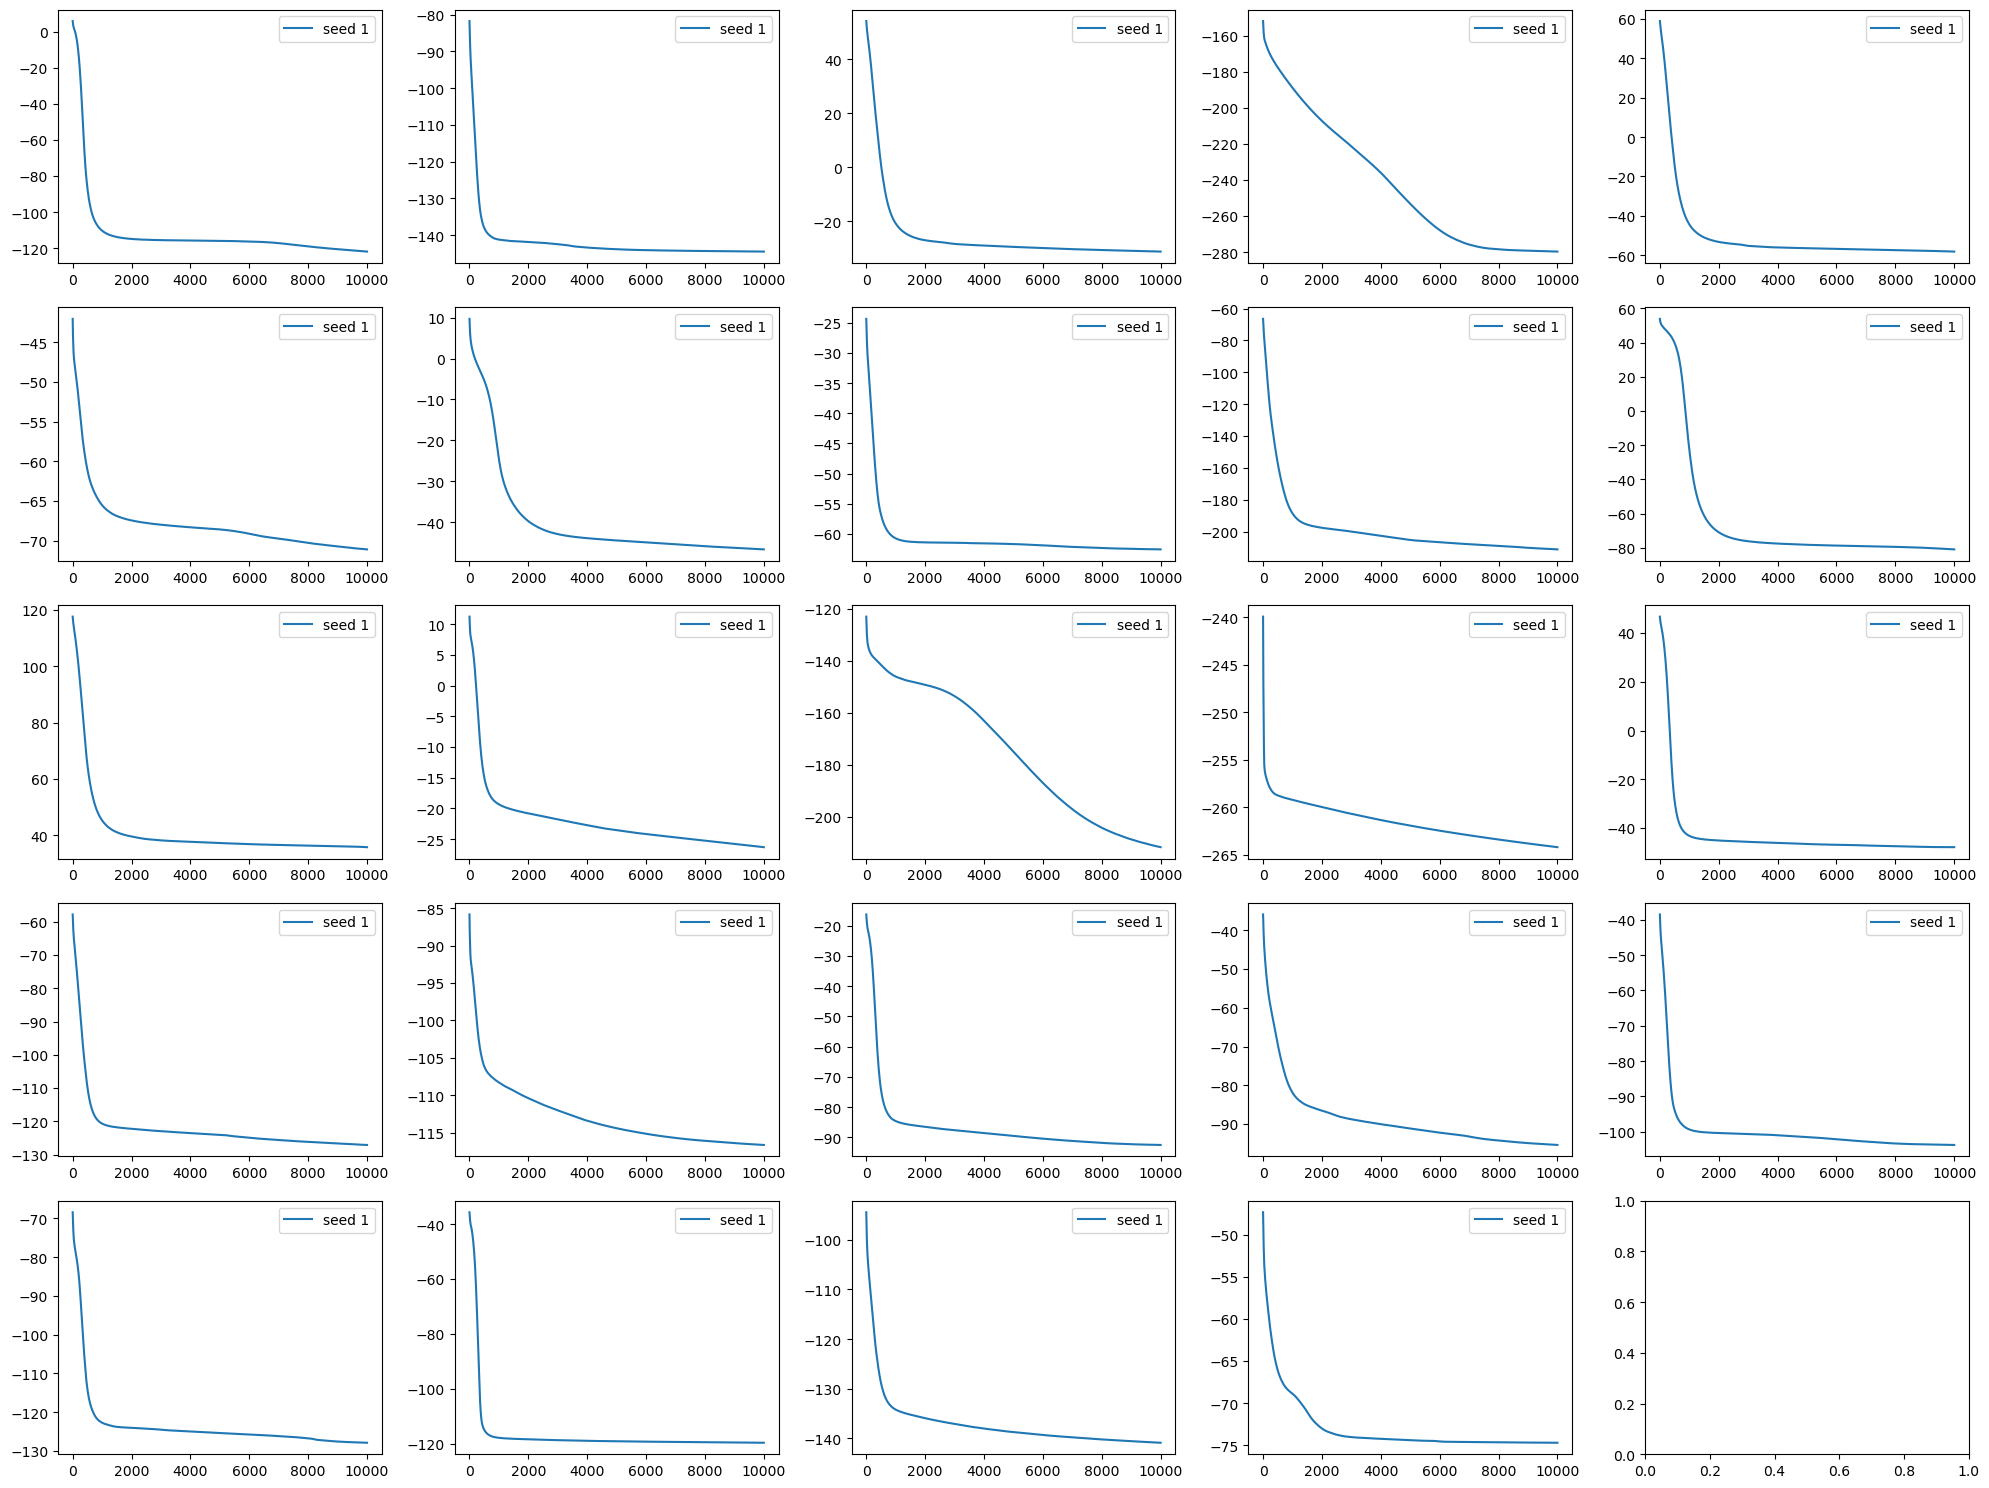

In [4]:
#plot all the loss traces. subplot per run and line per seed
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(1,25):
    ax = axs[(i-1)//5, (i-1)%5]
    for j in range(1,2):
        if loss_traces[(i,j)] is not None:
            ax.plot(loss_traces[(i,j)][:,0],loss_traces[(i,j)][:,-1], label=f'seed {j}')
    # ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
plt.tight_layout()
plt.show()

(1130.0, 1160.0)

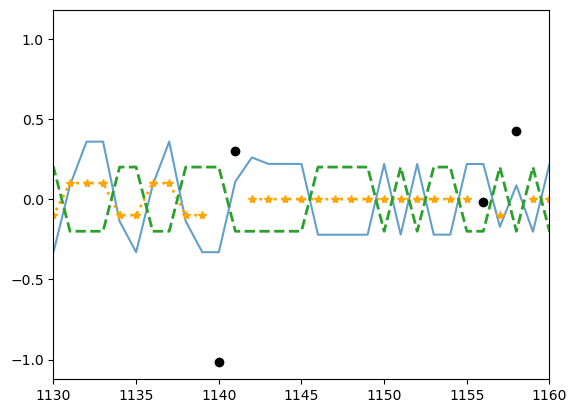

In [5]:
i = 3
plt.plot(exp_datasets[i-1][0], 'o', label='experimental', color='black', linewidth=2)
# plt.plot(mean_as[i-1], '-x', label='prior mean a', color='blue', alpha=0.5)
plt.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
plt.plot(0.1*exp_datasets[i-1][1], ':*', label='experimental', color='orange', linewidth=2)
plt.plot(0.2*exp_datasets[i-1][2], '--', label='experimental', color='tab:green', linewidth=2)
# plt.xlim([2100, 2150])
plt.xlim([1130, 1160])

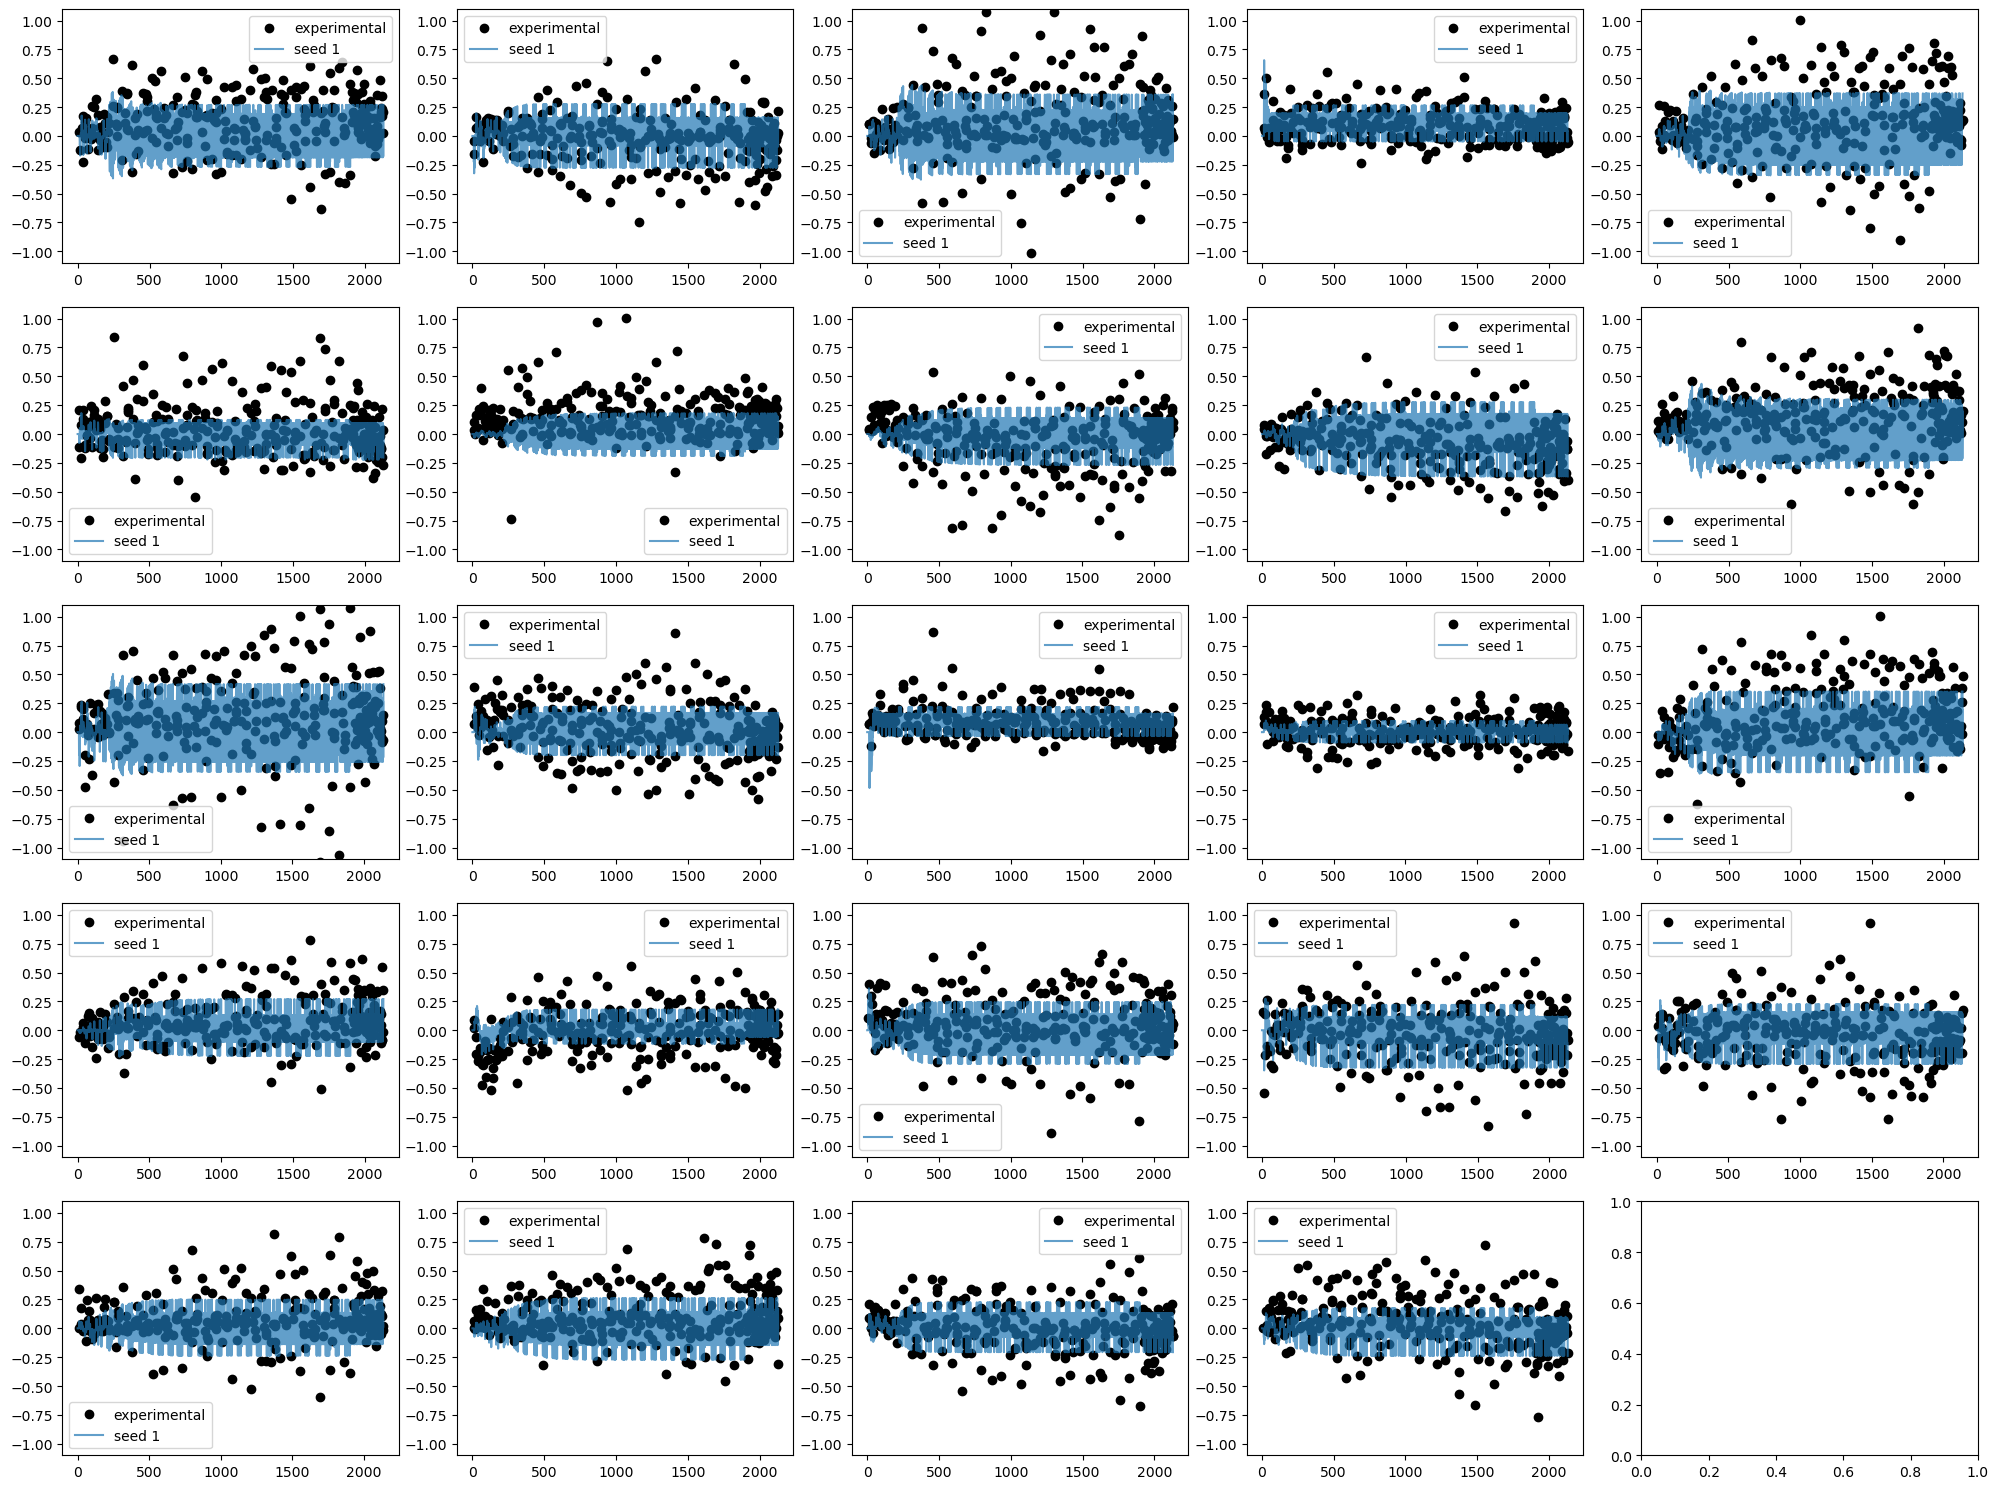

In [6]:
#plot output traces vs experimental data. subplot per run and line per seed
fig, axs = plt.subplots(5, 5, figsize=(20, 15))
for i in range(1, 25):
    ax = axs[(i-1)//5, (i-1)%5]
    ax.plot(exp_datasets[i-1][0], 'o', label='experimental', color='black', linewidth=2)
    for j in range(1,2):
        # ax.plot(mean_as[i-1], label='prior mean a', color='blue', alpha=0.5)
        if output_traces[(i,j)] is not None:
            ax.plot(output_traces[(i,j)], label=f'seed {j}', alpha=0.7)
        
    # ax.set_title(f'Run {i} ({paradigm_[i]})')
    ax.legend()
    ax.set_ylim([-1.1, 1.1])
plt.tight_layout()
plt.show()

In [7]:
outs = []
fit_outs = []
for i in range(1, 25):
            ys = exp_datasets[i-1][1]
            qs = exp_datasets[i-1][2]
            aa = exp_datasets[i-1][0]
            outs.append(extract_mem_updates(ys, qs, aa,-32))
            # fit_outs.append(extract_mem_updates(ys, qs, mean_as[i-1],-32))
            try:
                fit_outs.append(extract_mem_updates(ys, qs, output_traces[(i,1)],-32))
            except:
                # fit_outs.append(None)
                pass


(-0.2, 0.5)

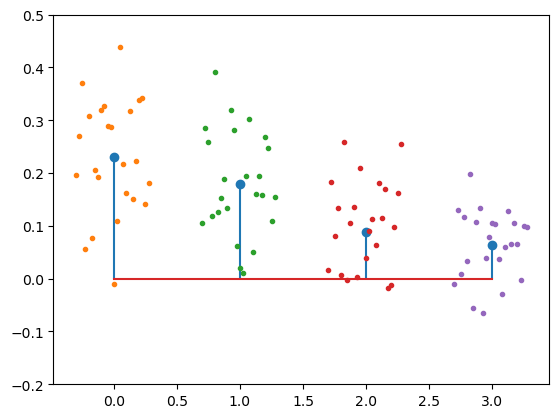

In [8]:
y_alignment = np.array([1,1,-1,-1])
plt.stem(y_alignment * np.mean(outs, axis=-1).mean(axis=0), 'x')
for ii in range(4):
    xdata = -0.3+0.6/24*np.arange(24) + ii
    ydata = y_alignment[ii] * np.mean(outs, axis=-1)[:,ii]
    plt.plot(xdata, ydata,'.')
plt.ylim([-0.2, 0.5])

(-0.2, 0.5)

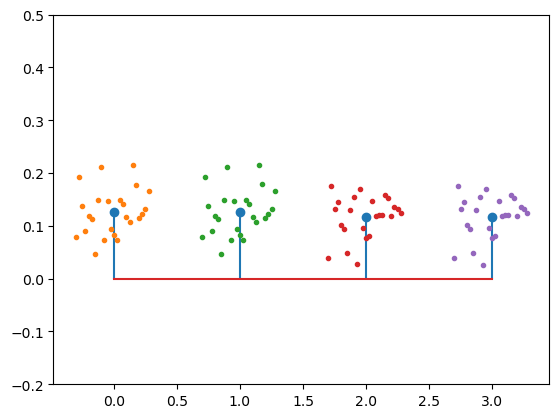

In [9]:
y_alignment = np.array([1,1,-1,-1])
plt.stem(y_alignment * np.mean(fit_outs, axis=-1).mean(axis=0), 'x')
for ii in range(4):
    ydata = y_alignment[ii] * np.mean(fit_outs, axis=-1)[:,ii]
    xdata = -0.3+0.6/24*np.arange(len(ydata)) + ii
    plt.plot(xdata, ydata,'.')
plt.ylim([-0.2, 0.5])

In [10]:
def consistency(ys=None, qs=None):
    iys_blocks = np.concatenate([~np.isnan(ys[:-1]) & ~np.isnan(ys[1:]), [~np.isnan(ys[-2]) & ~np.isnan(ys[-1])]])
    consistency = ys[:-1] * ys[1:] * iys_blocks[:-1] * iys_blocks[1:] 
    consistency = consistency[iys_blocks[1:]]
    return np.nanmean(consistency)

In [11]:
for i in range(1, 25):
    ys = exp_datasets[i-1][1]
    qs = exp_datasets[i-1][2]
    print(f'Run {i} consistency: {consistency(ys, qs)}')

Run 1 consistency: -0.07297297297297298
Run 2 consistency: -0.08243243243243244
Run 3 consistency: -0.04048582995951417
Run 4 consistency: -0.048582995951417005
Run 5 consistency: -0.0862533692722372
Run 6 consistency: -0.0876010781671159
Run 7 consistency: -0.017543859649122806
Run 8 consistency: -0.05383580080753701
Run 9 consistency: -0.048582995951417005
Run 10 consistency: -0.09433962264150944
Run 11 consistency: -0.05510752688172043
Run 12 consistency: -0.04993252361673414
Run 13 consistency: -0.06477732793522267
Run 14 consistency: -0.06864064602960969
Run 15 consistency: -0.0553306342780027
Run 16 consistency: -0.07681940700808626
Run 17 consistency: -0.06756756756756757
Run 18 consistency: -0.05652759084791386
Run 19 consistency: -0.052702702702702706
Run 20 consistency: -0.07940780619111709
Run 21 consistency: -0.056451612903225805
Run 22 consistency: -0.07557354925775979
Run 23 consistency: -0.07152496626180836
Run 24 consistency: -0.09152086137281291


In [12]:
params = torch.load(f'{result_root}/mem_upd_try5/run1_seed1/params.pt')

In [13]:
params

OrderedDict([('gen.log_learning_rate', tensor([-5.0657], device='cuda:0')),
             ('gen.log_learning_rate_decay',
              tensor([-0.7500], device='cuda:0')),
             ('gen.sigma_b', tensor([0.8355], device='cuda:0')),
             ('gen.output_scale', tensor([0.3500], device='cuda:0')),
             ('gen.sp_weight_decay', tensor([-3.6141], device='cuda:0')),
             ('gen.q_scale', tensor([1.1016], device='cuda:0')),
             ('gen.sigma_x', tensor([0.0002], device='cuda:0')),
             ('gen.tauelpf_m1', tensor([0.3278], device='cuda:0')),
             ('gen._z_biases',
              tensor([ 0.1696, -1.2966,  0.3153,  0.9196, -0.1853, -1.0896, -0.2633,  0.3830,
                      -0.6385,  1.4271, -1.3746, -0.0525, -0.3421, -2.0838,  2.0190,  0.1966,
                       0.2106,  0.2055,  0.5721,  1.3064, -0.0335,  2.3592,  0.4094,  1.0403,
                       0.4566,  1.0188, -1.2642,  0.4593,  0.5442, -1.7211, -0.5568, -1.3337,
              

In [14]:
for i in range(1, 25):
            # plt.subplot(5,5,i)
            main_polarity = polarity(exp_datasets[i-1][1], exp_datasets[i-1][2])
            print(f'Run {i} main polarity: {main_polarity}')


Run 1 main polarity: 1.0
Run 2 main polarity: -1.0
Run 3 main polarity: -1.0
Run 4 main polarity: 1.0
Run 5 main polarity: -1.0
Run 6 main polarity: 1.0
Run 7 main polarity: 1.0
Run 8 main polarity: -1.0
Run 9 main polarity: 1.0
Run 10 main polarity: 1.0
Run 11 main polarity: -1.0
Run 12 main polarity: -1.0
Run 13 main polarity: 1.0
Run 14 main polarity: -1.0
Run 15 main polarity: 1.0
Run 16 main polarity: -1.0
Run 17 main polarity: -1.0
Run 18 main polarity: 1.0
Run 19 main polarity: 1.0
Run 20 main polarity: -1.0
Run 21 main polarity: -1.0
Run 22 main polarity: 1.0
Run 23 main polarity: -1.0
Run 24 main polarity: 1.0
